🚀 Master started: 2025-11-11 15:56:38.082523
✅ UC ready
  Catalog: influencer
  Volume CSV: /Volumes/influencer/raw/ingest_vol/Influencers_dataset.csv

🏗️ STEP 1: Ingestion → Bronze
ℹ️ Using existing UC Volume file: dbfs:/Volumes/influencer/raw/ingest_vol/Influencers_dataset.csv
✅ Bronze: influencer.raw.posts_bronze

🧹 STEP 2: Cleaning → Silver
✅ Silver: influencer.curated.posts_silver

🧠 STEP 3: Feature Engineering + Alignment (HashingTF)
✅ STEP 3 complete (HASH_DIM = 512 )

💡 STEP 4: Success scoring (heuristic)
✅ Predictions: influencer.ml.creator_predictions

📊 STEP 5: Recommendations & Visuals
✅ Top influencers table: influencer.curated.top_influencers


/databricks/python/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/databricks/python/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


ℹ️ Visuals skipped (likely headless job). Error: [Errno 2] No such file or directory: 'dbfs:/Volumes/influencer/raw/ingest_vol/artifacts/corr_heatmap.png'

🔔 STEP 6: Monitoring & Alerts (simulated)
ℹ️ Alert heatmap skipped (headless job). Error: [Errno 2] No such file or directory: 'dbfs:/Volumes/influencer/raw/ingest_vol/artifacts/alerts_heatmap.png'

🎉 Pipeline complete: 2025-11-11 15:57:06.874691
Delta outputs:
  • influencer.raw.posts_bronze
  • influencer.curated.posts_silver
  • influencer.curated.posts_with_emb
  • influencer.curated.brands_with_emb
  • influencer.curated.post_brand_alignment
  • influencer.ml.creator_features
  • influencer.ml.creator_predictions
  • influencer.curated.top_influencers
  • influencer.curated.kpi_live_summary
  • influencer.curated.alert_summary


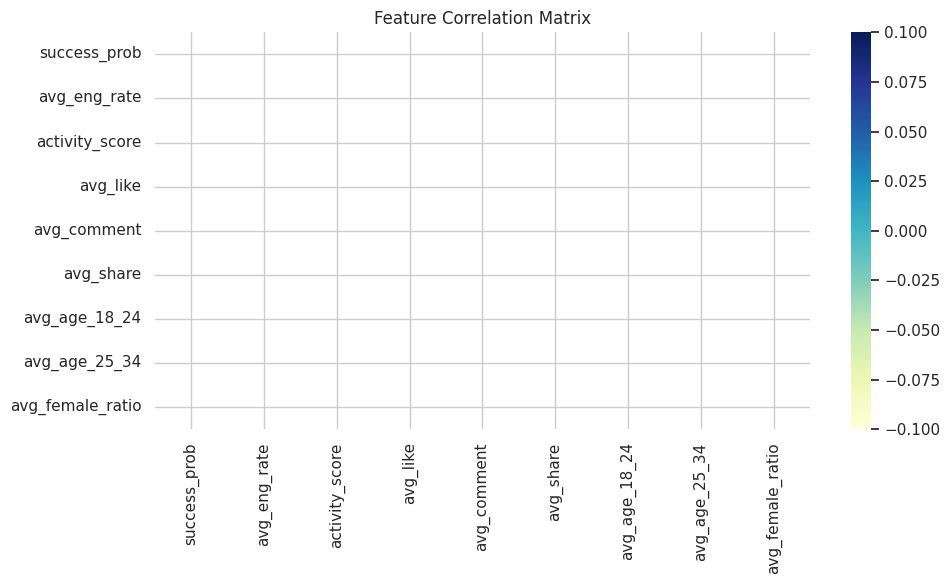

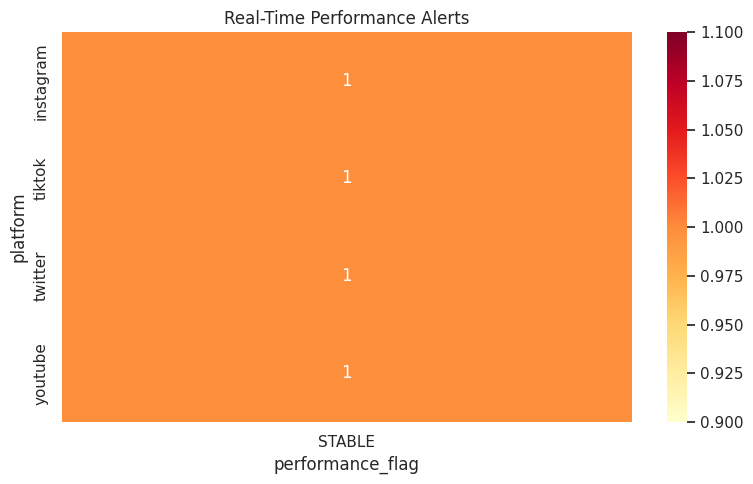

In [0]:
# ============================================================
# MASTER PIPELINE — Influencer Analytics (All steps inline)
# Serverless/Jobs-safe: no external %run, no heavy ML models
# ============================================================

from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("🚀 Master started:", datetime.now())

# -----------------------------
# STEP 0: CONFIG + UC OBJECTS
# -----------------------------
CATALOG      = "influencer"          # UC catalog
SCHEMA_RAW   = "raw"                  # bronze schema
SCHEMA_CUR   = "curated"              # silver/curated schema
SCHEMA_ML    = "ml"                   # features/preds schema
VOLUME_NAME  = "ingest_vol"           # UC Volume for files

# Your original workspace CSV (uploaded via UI)
WORKSPACE_CSV = "/Workspace/Users/ragutudeepika68730@gmail.com/Big_data_analytics_pipeline/Influencers_dataset.csv"
# Where we'll keep a jobs-safe copy of the CSV
VOLUME_CSV    = f"/Volumes/{CATALOG}/{SCHEMA_RAW}/{VOLUME_NAME}/Influencers_dataset.csv"

def tbl(name: str) -> str:
    return f"{CATALOG}.{name}"

# Ensure UC objects exist
spark.sql(f"CREATE CATALOG IF NOT EXISTS {CATALOG}")
spark.sql(f"CREATE SCHEMA  IF NOT EXISTS {CATALOG}.{SCHEMA_RAW}")
spark.sql(f"CREATE SCHEMA  IF NOT EXISTS {CATALOG}.{SCHEMA_CUR}")
spark.sql(f"CREATE SCHEMA  IF NOT EXISTS {CATALOG}.{SCHEMA_ML}")
spark.sql(f"CREATE VOLUME  IF NOT EXISTS {CATALOG}.{SCHEMA_RAW}.{VOLUME_NAME}")

print("✅ UC ready")
print("  Catalog:", CATALOG)
print("  Volume CSV:", VOLUME_CSV)

def _exists(dbfs_path: str) -> bool:
    try:
        dbutils.fs.ls(dbfs_path.rstrip("/"))
        return True
    except Exception:
        return False

def mirror_to_volume(ws_path: str, vol_path: str) -> str:
    """Copy CSV into UC Volume so serverless executors can read it."""
    vol_dbfs = "dbfs:" + vol_path
    if _exists(vol_dbfs):
        print(f"ℹ️ Using existing UC Volume file: {vol_dbfs}")
        return vol_path

    candidates = []
    if ws_path.startswith("/Workspace/"): candidates.append("dbfs:" + ws_path)
    if ws_path.startswith("dbfs:/"):      candidates.append(ws_path)
    candidates.append("dbfs:/FileStore/Influencers_dataset.csv")  # UI fallback

    last_err = None
    for src in candidates:
        if not _exists(src):
            continue
        try:
            try: dbutils.fs.rm(vol_dbfs, recurse=False)
            except: pass
            dbutils.fs.cp(src, vol_dbfs)
            print(f"✅ Copied {src} → {vol_dbfs}")
            return vol_path
        except Exception as e:
            last_err = e
            print(f"⚠️ Copy failed {src} → {vol_dbfs}: {e}")

    raise RuntimeError(
        "❌ Could not stage CSV to UC Volume.\n"
        f"Upload to:\n  {vol_path}\n"
        "Or copy once via:\n"
        f"  dbutils.fs.cp('dbfs:/FileStore/Influencers_dataset.csv','dbfs:{vol_path}')\n"
        f"Last error: {last_err}"
    )

# -----------------------------
# STEP 1: INGEST → BRONZE
# -----------------------------
print("\n🏗️ STEP 1: Ingestion → Bronze")
resolved_csv = mirror_to_volume(WORKSPACE_CSV, VOLUME_CSV)

bronze_src = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .option("multiLine", True)
         .option("mode", "PERMISSIVE")
         .option("quote", '"').option("escape", '"')
         .csv(resolved_csv)
)

cols = set(bronze_src.columns)
def pick(cands):
    for c in cands:
        if c in cols: return F.col(c)
    return None
def OR(expr, fallback): return expr if expr is not None else fallback

PLATFORM=["platform","source_platform","source"]
CREATOR =["creator_id","user_id","handle","username","channel_id","author_id"]
POSTID  =["post_id","content_id","id","tweet_id","video_id"]
TIME    =["timestamp","created_at","date","datetime","published_at"]
TEXT    =["text","caption","title","body","description"]
LIKE    =["like_count","likes"]
COMM    =["comment_count","comments","reply_count"]
SHARE   =["share_count","shares","retweets"]
COUNTRY =["audience_country","country"]
AGE18   =["audience_age_18_24","age_18_24"]
AGE25   =["audience_age_25_34","age_25_34"]
FEM     =["audience_gender_f","female_ratio"]

synthetic_pid = F.concat(F.lit("p_"), F.monotonically_increasing_id())

bronze = bronze_src.select(
    F.lower(F.trim(OR(pick(PLATFORM), F.lit("unknown")))).alias("platform"),
    F.trim(OR(pick(CREATOR), F.lit("unknown_creator"))).alias("creator_id"),
    OR(pick(POSTID), synthetic_pid).alias("post_id"),
    OR(pick(TIME), F.current_timestamp()).alias("timestamp"),
    F.trim(OR(pick(TEXT), F.lit(""))).alias("text"),
    F.coalesce(OR(pick(LIKE),  F.lit(None)).cast("int"),   F.lit(0)).alias("like_count"),
    F.coalesce(OR(pick(COMM),  F.lit(None)).cast("int"),   F.lit(0)).alias("comment_count"),
    F.coalesce(OR(pick(SHARE), F.lit(None)).cast("int"),   F.lit(0)).alias("share_count"),
    F.upper(OR(pick(COUNTRY), F.lit(None))).alias("audience_country"),
    F.coalesce(OR(pick(AGE18), F.lit(None)).cast("double"),F.lit(0.0)).alias("audience_age_18_24"),
    F.coalesce(OR(pick(AGE25), F.lit(None)).cast("double"),F.lit(0.0)).alias("audience_age_25_34"),
    F.coalesce(OR(pick(FEM),   F.lit(None)).cast("double"),F.lit(0.0)).alias("audience_gender_f")
)

(bronze.write.format("delta")
      .mode("overwrite").option("overwriteSchema","true")
      .saveAsTable(tbl(f"{SCHEMA_RAW}.posts_bronze")))
print("✅ Bronze:", tbl(f"{SCHEMA_RAW}.posts_bronze"))

# -----------------------------
# STEP 2: CLEAN → SILVER
# -----------------------------
print("\n🧹 STEP 2: Cleaning → Silver")

b = spark.table(tbl(f"{SCHEMA_RAW}.posts_bronze"))
silver = (
    b.withColumn("like_count", F.coalesce(F.col("like_count").cast("int"), F.lit(0)))
     .withColumn("comment_count", F.coalesce(F.col("comment_count").cast("int"), F.lit(0)))
     .withColumn("share_count", F.coalesce(F.col("share_count").cast("int"), F.lit(0)))
     .withColumn("audience_age_18_24", F.coalesce(F.col("audience_age_18_24").cast("double"), F.lit(0.0)))
     .withColumn("audience_age_25_34", F.coalesce(F.col("audience_age_25_34").cast("double"), F.lit(0.0)))
     .withColumn("audience_gender_f", F.coalesce(F.col("audience_gender_f").cast("double"), F.lit(0.0)))
     .withColumn("platform", F.lower(F.trim("platform")))
     .withColumn("creator_id", F.trim("creator_id"))
     .withColumn("post_id", F.trim("post_id"))
     .withColumn("text", F.trim("text"))
     .withColumn("timestamp", F.coalesce(F.to_timestamp("timestamp"), F.current_timestamp()))
     .filter("post_id IS NOT NULL AND creator_id IS NOT NULL AND platform IS NOT NULL")
     .dropDuplicates(["post_id"])
     .withColumn("creator_norm_id", F.sha2(F.concat_ws(":", "platform", "creator_id"), 256))
     .withColumn("eng_rate_proxy", F.col("like_count") + F.col("comment_count") + F.col("share_count"))
)
(silver.write.format("delta")
       .mode("overwrite").option("overwriteSchema","true")
       .saveAsTable(tbl(f"{SCHEMA_CUR}.posts_silver")))
print("✅ Silver:", tbl(f"{SCHEMA_CUR}.posts_silver"))

# -----------------------------
# STEP 3: FEATURES + BRAND ALIGNMENT (LIGHTWEIGHT, NO-IDF)
# -----------------------------
print("\n🧠 STEP 3: Feature Engineering + Alignment (HashingTF)")

from pyspark.sql import types as T
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF

posts = spark.table(tbl(f"{SCHEMA_CUR}.posts_silver")).fillna({"text": ""})

tok = RegexTokenizer(inputCol="text", outputCol="tokens_raw", pattern="\\W+", toLowercase=True)
rm  = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens")
HASH_DIM = 512  # reduce to 256 if your corpus is huge
tf  = HashingTF(inputCol="tokens", outputCol="text_vec", numFeatures=HASH_DIM, binary=True)

posts_tok = tok.transform(posts)
posts_tok = rm.transform(posts_tok)
posts_vec = tf.transform(posts_tok)

(posts_vec.select(
   "platform","creator_id","creator_norm_id","post_id","timestamp","text",
   "like_count","comment_count","share_count","audience_country",
   "audience_age_18_24","audience_age_25_34","audience_gender_f","text_vec"
).write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable(tbl(f"{SCHEMA_CUR}.posts_with_emb")))

brands = spark.createDataFrame([
  ("b_eco_fashion","Sustainable fashion eco friendly materials ethical sourcing"),
  ("b_gaming","High performance gaming gear esports streaming reviews"),
  ("b_clean_beauty","Clean beauty cruelty free vegan skincare cosmetics")
], ["brand_id","text"])
brands_vec = tf.transform(rm.transform(tok.transform(brands))).select(
    F.col("brand_id"),
    F.col("text").alias("brand_desc"),
    F.col("text_vec").alias("brand_vec")
)
(brands_vec.write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable(tbl(f"{SCHEMA_CUR}.brands_with_emb")))

@F.udf(T.FloatType())
def cosine_sim(v1, v2):
    if v1 is None or v2 is None: return 0.0
    try:
        a = v1.toArray(); b = v2.toArray()
    except: return 0.0
    import numpy as np
    na = float(np.linalg.norm(a)); nb = float(np.linalg.norm(b))
    return float(np.dot(a,b)/(na*nb)) if na>0 and nb>0 else 0.0

p = spark.table(tbl(f"{SCHEMA_CUR}.posts_with_emb")).select(
    "platform","creator_id","creator_norm_id","post_id","timestamp","text",
    "like_count","comment_count","share_count","audience_country",
    "audience_age_18_24","audience_age_25_34","audience_gender_f","text_vec"
)
b = spark.table(tbl(f"{SCHEMA_CUR}.brands_with_emb")).select("brand_id","brand_desc","brand_vec")

align = p.crossJoin(b).withColumn("content_alignment", cosine_sim("text_vec","brand_vec"))
(align.write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable(tbl(f"{SCHEMA_CUR}.post_brand_alignment")))

# Creator-level features
w_creator = Window.partitionBy("creator_norm_id")
features = (
    posts.withColumn("total_posts", F.count("post_id").over(w_creator))
         .withColumn("avg_eng_rate", F.mean("eng_rate_proxy").over(w_creator))
         .withColumn("avg_like", F.mean("like_count").over(w_creator))
         .withColumn("avg_comment", F.mean("comment_count").over(w_creator))
         .withColumn("avg_share", F.mean("share_count").over(w_creator))
         .withColumn("avg_age_18_24", F.mean("audience_age_18_24").over(w_creator))
         .withColumn("avg_age_25_34", F.mean("audience_age_25_34").over(w_creator))
         .withColumn("avg_female_ratio", F.mean("audience_gender_f").over(w_creator))
         .withColumn("avg_align", F.when(F.col("audience_age_25_34") > F.col("audience_age_18_24"), 1).otherwise(0))
         .withColumn("activity_score", (F.col("avg_eng_rate") / (1 + F.col("total_posts"))))
         .select("creator_norm_id","platform","creator_id","total_posts","avg_eng_rate","avg_like",
                 "avg_comment","avg_share","avg_age_18_24","avg_age_25_34","avg_female_ratio",
                 "avg_align","activity_score")
         .dropDuplicates(["creator_norm_id"])
)
(features.write.format("delta").mode("overwrite").option("overwriteSchema","true")
         .saveAsTable(tbl(f"{SCHEMA_ML}.creator_features")))
print("✅ STEP 3 complete (HASH_DIM =", HASH_DIM, ")")

# -----------------------------
# STEP 4: HEURISTIC SUCCESS SCORING → PREDICTIONS
# -----------------------------
print("\n💡 STEP 4: Success scoring (heuristic)")

df = spark.table(tbl(f"{SCHEMA_ML}.creator_features")).fillna(0)
feat_cols = [
    "avg_eng_rate","avg_like","avg_comment","avg_share",
    "avg_female_ratio","activity_score","avg_age_25_34","avg_align"
]

eps = 1e-9
for c in feat_cols:
    q = df.approxQuantile(c, [0.05, 0.95], 1e-3)
    lo = float(q[0]) if len(q) > 0 else 0.0
    hi = float(q[1]) if len(q) > 1 else lo + 1.0
    if hi - lo <= 0: hi = lo + 1.0
    norm = (F.col(c) - F.lit(lo)) / F.lit((hi - lo) + eps)
    norm = F.when(norm < 0, 0).when(norm > 1, 1).otherwise(norm)
    df = df.withColumn(f"norm_{c}", norm)

w = {"avg_eng_rate":0.30,"avg_like":0.10,"avg_comment":0.10,"avg_share":0.10,
     "avg_female_ratio":0.05,"activity_score":0.15,"avg_age_25_34":0.10,"avg_align":0.10}

raw = None
for c, wt in w.items():
    term = F.col(f"norm_{c}") * F.lit(wt)
    raw = term if raw is None else (raw + term)

df = df.withColumn("raw_score", raw)
df = df.withColumn("success_prob", 1 / (1 + F.exp(-6 * (F.col("raw_score") - 0.5))))
thr = float(df.approxQuantile("raw_score", [0.6], 1e-3)[0])
df = df.withColumn("label", (F.col("raw_score") > F.lit(thr)).cast("int"))

(df.select("creator_norm_id","success_prob","label")
   .write.format("delta").mode("overwrite").option("overwriteSchema","true")
   .saveAsTable(tbl(f"{SCHEMA_ML}.creator_predictions")))
print("✅ Predictions:", tbl(f"{SCHEMA_ML}.creator_predictions"))

# -----------------------------
# STEP 5: RECOMMENDATIONS + VISUALS (saved to UC Volume)
# -----------------------------
print("\n📊 STEP 5: Recommendations & Visuals")

joined = spark.table(tbl(f"{SCHEMA_ML}.creator_features"))\
              .join(spark.table(tbl(f"{SCHEMA_ML}.creator_predictions")), "creator_norm_id")

w_plat = Window.partitionBy("platform").orderBy(F.desc("success_prob"))
top10 = (joined
         .withColumn("rnk", F.rank().over(w_plat))
         .filter("rnk <= 10")
         .select("platform","creator_id","success_prob","avg_eng_rate","activity_score",
                 "avg_age_18_24","avg_age_25_34","avg_female_ratio","rnk"))
(top10.write.mode("overwrite").format("delta")
      .option("overwriteSchema","true")
      .saveAsTable(tbl(f"{SCHEMA_CUR}.top_influencers")))
print("✅ Top influencers table:", tbl(f"{SCHEMA_CUR}.top_influencers"))

ART_DIR = f"/Volumes/{CATALOG}/{SCHEMA_RAW}/{VOLUME_NAME}/artifacts"
dbutils.fs.mkdirs("dbfs:" + ART_DIR)

try:
    import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    sns.set(style="whitegrid", palette="coolwarm")

    pdf = joined.select(
        "platform","success_prob","avg_eng_rate","activity_score",
        "avg_like","avg_comment","avg_share","avg_age_18_24","avg_age_25_34","avg_female_ratio"
    ).toPandas()

    # 1) Correlation heatmap
    plt.figure(figsize=(10,6))
    sns.heatmap(pdf.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Feature Correlation Matrix")
    heatmap_path = f"{ART_DIR}/corr_heatmap.png"
    plt.tight_layout(); plt.savefig("dbfs:" + heatmap_path); plt.close()

    # 2) Success probability by platform
    plt.figure(figsize=(9,5))
    sns.violinplot(x="platform", y="success_prob", data=pdf, inner="quartile", linewidth=1.2)
    plt.title("Success Probability by Platform")
    violin_path = f"{ART_DIR}/success_by_platform.png"
    plt.tight_layout(); plt.savefig("dbfs:" + violin_path); plt.close()

    # 3) Engagement vs success
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="avg_eng_rate", y="success_prob", hue="platform", size="activity_score",
                    data=pdf, alpha=0.75, sizes=(30,180))
    plt.title("Engagement Rate vs Success Probability")
    scatter_path = f"{ART_DIR}/engagement_vs_success.png"
    plt.tight_layout(); plt.savefig("dbfs:" + scatter_path); plt.close()

    print("✅ Visuals saved:")
    print("   -", heatmap_path)
    print("   -", violin_path)
    print("   -", scatter_path)
except Exception as e:
    print("ℹ️ Visuals skipped (likely headless job). Error:", e)

# -----------------------------
# STEP 6: MONITORING SIM + ALERTS
# -----------------------------
print("\n🔔 STEP 6: Monitoring & Alerts (simulated)")

stream_df = joined.withColumn("recent_eng_rate", F.col("avg_eng_rate") * (1 + F.rand()*0.3 - 0.15))
agg_df = (stream_df.groupBy("platform")
          .agg(F.avg("recent_eng_rate").alias("current_eng_rate"),
               F.avg("success_prob").alias("avg_success_prob"),
               F.count("*").alias("num_creators"))
          .orderBy(F.desc("current_eng_rate")))
(agg_df.write.mode("overwrite").format("delta")
      .saveAsTable(tbl(f"{SCHEMA_CUR}.kpi_live_summary")))

alerts = stream_df.withColumn(
    "performance_flag",
    F.when(F.col("recent_eng_rate") < F.col("avg_eng_rate")*0.75, "DROP")
     .when(F.col("recent_eng_rate") > F.col("avg_eng_rate")*1.25, "SPIKE")
     .otherwise("STABLE")
)
alert_summary = alerts.groupBy("platform","performance_flag").count()
(alert_summary.write.mode("overwrite").format("delta")
      .saveAsTable(tbl(f"{SCHEMA_CUR}.alert_summary")))

# Save alert heatmap
try:
    import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
    a_pdf = alert_summary.toPandas()
    pivot = a_pdf.pivot(index="platform", columns="performance_flag", values="count").fillna(0)
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, cmap="YlOrRd", fmt=".0f")
    plt.title("Real-Time Performance Alerts")
    alerts_path = f"{ART_DIR}/alerts_heatmap.png"
    plt.tight_layout(); plt.savefig("dbfs:" + alerts_path); plt.close()
    print("✅ Alerts heatmap saved:", alerts_path)
except Exception as e:
    print("ℹ️ Alert heatmap skipped (headless job). Error:", e)

print("\n🎉 Pipeline complete:", datetime.now())
print("Delta outputs:")
print("  •", tbl(f"{SCHEMA_RAW}.posts_bronze"))
print("  •", tbl(f"{SCHEMA_CUR}.posts_silver"))
print("  •", tbl(f"{SCHEMA_CUR}.posts_with_emb"))
print("  •", tbl(f"{SCHEMA_CUR}.brands_with_emb"))
print("  •", tbl(f"{SCHEMA_CUR}.post_brand_alignment"))
print("  •", tbl(f"{SCHEMA_ML}.creator_features"))
print("  •", tbl(f"{SCHEMA_ML}.creator_predictions"))
print("  •", tbl(f"{SCHEMA_CUR}.top_influencers"))
print("  •", tbl(f"{SCHEMA_CUR}.kpi_live_summary"))
print("  •", tbl(f"{SCHEMA_CUR}.alert_summary"))
